In [1]:
from collections import Counter
import networkx as nx
import os
import pandas as pd
import requests
import re
import wikipedia as wiki
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta, datetime
import sys

In [ ]:
'''
This script mines all dates in the ego article and its out-links in order to produce a timeline of all relevant articles and to compare such timelines between language editions.

'''

In [2]:
os.chdir('path')

In [ ]:
#Import data and define list of articles to mine
lang = 'en'

#Import Edgelists
DF = pd.read_csv('%s_edgelist.csv'%lang)

#Produce NETWORK
NET = nx.from_pandas_edgelist(DF, create_using=nx.DiGraph())
print(nx.info(NET))
net_df = pd.DataFrame(index=list(NET.nodes))
net_df.index.name = 'Article'
net_df['Article'] = net_df.index
Articles = list(net_df['Article'])

In [ ]:
#Define query
def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i+n] 
            
#Define query
def query(request):
    request['action'] = 'parse'
    request['format'] = 'json'
    lastContinue = {}
    while True:
        req = request.copy()
        req.update(lastContinue)
        result = requests.get('https://%s.wikipedia.org/w/api.php'%lang, params=req).json()
        if 'error' in result:
            return []     
        if 'Error' in result:
            return []  
        if 'IncompleteRead' in result:
            return []
        if 'warnings' in result:
            print(result['warnings'])
        if 'parse' in result:
            yield result['parse']
        if 'continue' not in result:
            break
        if 'StopIteration' in result:
            return []
        if 'JSONDecodeError' in result:
            return []
        if 'Expecting value' in result:
            return []
        lastContinue = result['continue']

In [ ]:
#Define regex
reg1 = re.compile(r"\D(\d{4})\D")

#Get Dates in DE Network
en_dates_dic = {}
#de_dates_dic = {}

for n,i in enumerate(chunks(Articles, 1)):
    print('Getting Dates ',round(100*n/len(Articles),3),'%')
    for j in query({'page':'|'.join(i), 'prop':'wikitext'}):
        dates = j['wikitext']
        for k,v in dates.items():
            dates = v
            dates = re.sub('{{.*?}}', '', dates)
            dates = re.sub('\[(.*?)\]', '', dates)
            dates = dates.rsplit("== References ==")[0]
            dates = dates.rsplit("== External links ==")[0]
            dates = dates.rsplit("== Bibliography ==")[0]
            dates = dates.rsplit("== See also ==")[0]
            #dates = dates.rsplit("== Literatur ==")[0]
            #dates = dates.rsplit("== Weblinks ==")[0]
            #dates = dates.rsplit("== Siehe auch ==")[0]
            #dates = dates.rsplit("== Filme ==")[0] 
            #dates = dates.rsplit("=== Reportagen ===")[0] 
            dates = reg1.findall(dates)
            en_dates_dic[j['title']] = pd.Series(dates).value_counts()

In [ ]:
en_dates_df = pd.concat([x for x in en_dates_dic.values()], sort=True, axis=1).sum(axis=1)
en_dates_df = en_dates_df.reindex([str(x) for x in range(1000,2019)])
en_dates_df.index = en_dates_df.index.astype(int)
en_dates_df = df.fillna(0)
en_dates_df = df.to_frame()
en_dates_df.index.name = 'Date'
en_dates_df.columns = ['EN']
print(en_dates_df.describe())
en_dates_df.head()

In [5]:
#en1 = truncate then normalise
#truncate to 1800 & 1900
en1_df_10 = en_dates_df.copy()
en_df_1018 = en_dates_df.copy().truncate(before=1001,after=1799)
en1_df_18 = en_dates_df.copy().truncate(before=1800,after=2019)
en1_df_19 = en_dates_df.copy().truncate(before=1900, after=2019)

#normalise by truncated dates
en1_dates_10 = en1_df_10.sum(skipna=True,numeric_only=True)
print('Since 1000, there are dates: ',en1_df_10.sum())
en1_df_10 = en1_df_10 / en1_dates_10

en_dates_1018 = en_df_1018.sum(skipna=True,numeric_only=True)
print('\nBetween 1001 and 1799, there are dates: ',en_df_1018.sum())
en_df_1018 = en_df_1018 / en_dates_1018

en1_dates_18 = en1_df_18.sum(skipna=True,numeric_only=True)
print('\n Since 1800, there are dates: ',en1_df_18.sum())
en1_df_18 = en1_df_18 / en1_dates_18

en1_dates_19 = en1_df_19.sum(skipna=True,numeric_only=True)
print('\n Since 1900, there are dates: ',en1_df_19.sum())
en1_df_19 = en1_df_19 / en1_dates_19

Since 1000, there are dates:  sum    7308689.0
dtype: float64

Between 1001 and 1799, there are dates:  sum    348348.0
dtype: float64

 Since 1800, there are dates:  sum    6952092.0
dtype: float64

 Since 1900, there are dates:  sum    6414609.0
dtype: float64


In [8]:
# REPEAT PROCESS FOR DE ARTICLES

### Import DE with dates df
de_dates_df = pd.read_csv('de_Dates.csv')
de_dates_df = de_dates_df.set_index('Date')

display(de_dates_df.head())

,DE
Date,
1000,10343.0
1001,324.0
1002,300.0
1003,190.0
1004,208.0


In [9]:
#de1 = truncate then normalise
#truncate to 1800 & 1900
de_df_10 = de_dates_df.copy()
de_df_1018 = de_dates_df.copy().truncate(before=1001,after=1799)
de_df_18 = de_dates_df.copy().truncate(before=1800,after=2019)
de_df_19 = de_dates_df.copy().truncate(before=1900, after=2019)

#normalise by truncated dates
de_dates_10 = de_df_10.sum(skipna=True,numeric_only=True)
print('Since 1000, there are dates: ',de_df.sum())
de_df_10 = de_df_10 / de_dates_10

de_dates_1018 = de_df_1018.sum(skipna=True,numeric_only=True)
print('\nBetween 1001 and 1799, there are dates: ',de_df_1018.sum())
de_df_1018 = de_df_1018 / de_dates_1018

de_dates_18 = de_df_18.sum(skipna=True,numeric_only=True)
print('\n Since 1800, there are dates: ',de_df_18.sum())
de_df_18 = de_df_18 / de_dates_18

de_dates_19 = de_df_19.sum(skipna=True,numeric_only=True)
print('\n Since 1900, there are dates: ',de_df_19.sum())
de_df_19 = de_df_19 / de_dates_19

Since 1000, there are dates:  DE    4460037.0
dtype: float64

Between 1001 and 1799, there are dates:  DE    433167.0
dtype: float64

 Since 1800, there are dates:  DE    4016527.0
dtype: float64

 Since 1900, there are dates:  DE    3528637.0
dtype: float64


In [15]:
en1_df_10.columns = ['EN']
en1_df_18.columns = ['EN']
en1_df_19.columns = ['EN']
display(en1_df_18.head())

,EN
Date,
1800,0.000875
1801,0.000377
1802,0.000240
1803,0.000328
1804,0.000279


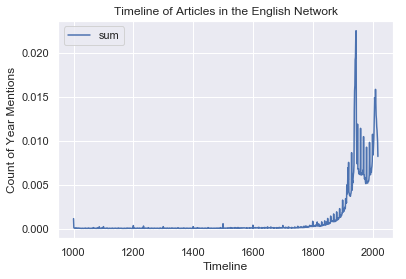

In [10]:
sns.set()
en1_df_10.plot()
plt.xlabel('Timeline')
plt.ylabel('Count of Year Mentions')
plt.title('Timeline of Articles in the English Network')
plt.savefig('DE_NET_1000.png')

Text(0.5, 1.0, 'Timeline of Articles in the English Network')

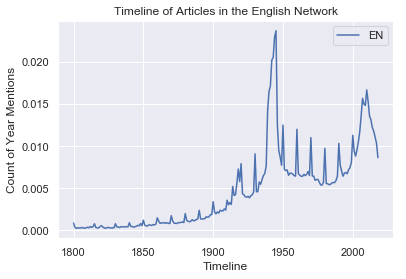

In [14]:
en1_df_18.plot()
plt.xlabel('Timeline')
plt.ylabel('Count of Year Mentions')
plt.title('Timeline of Articles in the English Network')
#plt.savefig('DE_NET_1800.png')

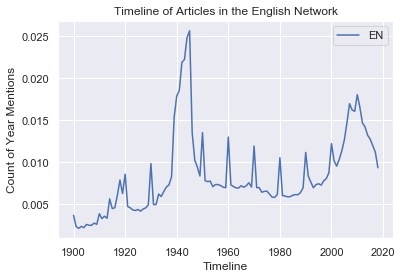

In [16]:
en1_df_19.plot()
plt.xlabel('Timeline')
plt.ylabel('Count of Year Mentions')
plt.title('Timeline of Articles in the English Network')
plt.savefig('DE_NET_1900.png')

In [17]:
#COMPARE EDITION NETWORK TIMELINES (NORM: ARTS)
COMB_dates_10 = pd.merge(en1_df_10, de_df_10, how='inner',on='Date',left_index=True)
COMB_dates_18 = pd.merge(en1_df_18, de_df_18, how='inner',on='Date',left_index=True)
COMB_dates_19 = pd.merge(en1_df_19, de_df_19, how='inner',on='Date',left_index=True)

In [35]:
#Change directory
os.chdir('path')

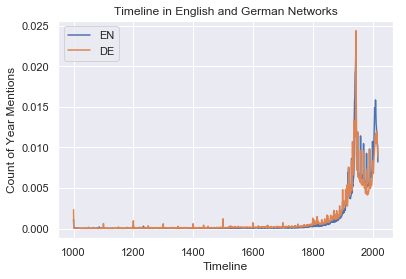

In [18]:
# PLOT TIMELINES OF NETWORKS - 1000
COMB_dates_10.plot()
plt.xlabel('Timeline')
plt.ylabel('Count of Year Mentions')
plt.title('Timeline in English and German Networks')
plt.savefig('NETS_1000.png')

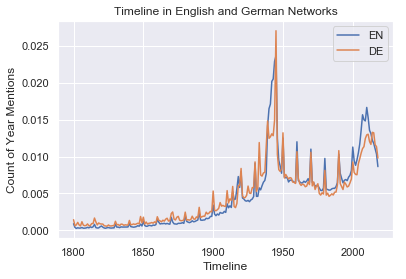

In [19]:
# PLOT TIMELINES OF NETWORKS - 1800
COMB_dates_18.plot()
plt.xlabel('Timeline')
plt.ylabel('Count of Year Mentions')
plt.title('Timeline in English and German Networks')
plt.savefig('NETS_FREQ_1800.png')

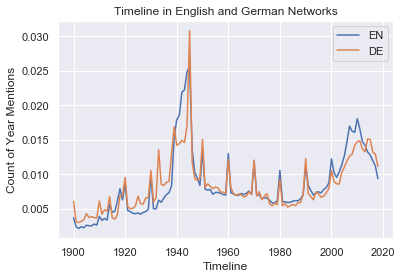

In [20]:
# PLOT TIMELINES OF NETWORKS - 1900
COMB_dates_19.plot()
plt.xlabel('Timeline')
plt.ylabel('Count of Year Mentions')
plt.title('Timeline in English and German Networks')
plt.savefig('NETS_FREQ_1900.png')

In [43]:
# PLOT TIMELINES OF EGO VS NETWORKS 
#import ego
os.chdir('path')
en_ego = pd.read_csv('en_Ego_Dates_1000.csv') 
en_ego = en_ego.set_index('Date')
de_ego = pd.read_csv('de_Ego_Dates_1000.csv')
de_ego = de_ego.set_index('Date')

#cd
os.chdir('path')

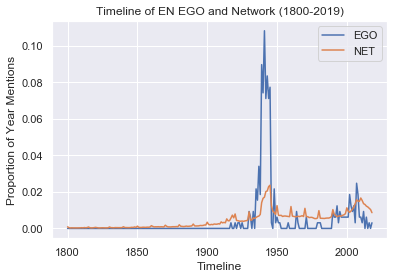

In [46]:
#English timeline
#take actions according to plots above - will need to truncate ego
en_ego_18 = en_ego.truncate(before=1800,after=2019)
en_ego_18.columns = ['EGO']
en1_df_18.columns = ['NET'] # add number

en_ego_net = pd.merge(en_ego_18,en1_df_18, how='inner',on='Date',left_index=True)
en_ego_net.plot()
plt.xlabel('Timeline')
plt.ylabel('Proportion of Year Mentions')
plt.title('Timeline of EN EGO and Network (1800-2019)')
plt.savefig('EN_EGONET_1800.png')

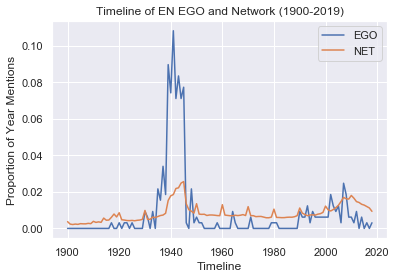

In [47]:
en_ego_19 = en_ego.truncate(before=1900,after=2019)
en_ego_19.columns = ['EGO']
en1_df_19.columns = ['NET'] # add number

en_ego_net19 = pd.merge(en_ego_19,en1_df_19, how='inner',on='Date',left_index=True)
en_ego_net19.plot()
plt.xlabel('Timeline')
plt.ylabel('Proportion of Year Mentions')
plt.title('Timeline of EN EGO and Network (1900-2019)')
plt.savefig('EN_EGONET_1900.png')

In [52]:
# PLOT TIMELINES OF EGO VS NETWORKS 
#18000
de_ego_18 = de_ego.truncate(before=1800,after=2019)
de_ego_18.columns = ['EGO']
#1900
de_ego_19 = de_ego.truncate(before=1900,after=2019)
de_ego_19.columns = ['EGO']
#net
de_df_18.columns = ['NET'] #add number

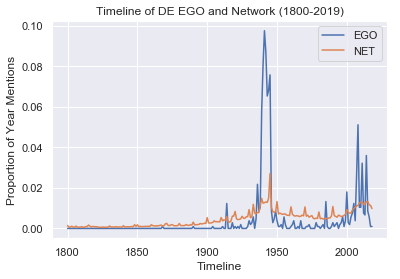

In [53]:
de_ego_net18 = pd.merge(de_ego_18,de_df_18, how='inner',on='Date',left_index=True)
de_ego_net18.plot()
plt.xlabel('Timeline')
plt.ylabel('Proportion of Year Mentions')
plt.title('Timeline of DE EGO and Network (1800-2019)')
plt.savefig('DE_EGONET_1800.png')

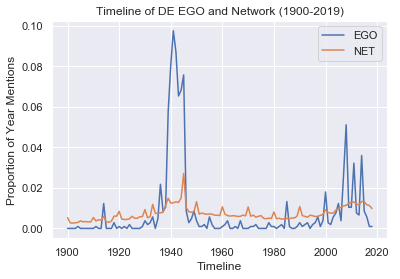

In [54]:
de_ego_net19 = pd.merge(de_ego_19,de_df_18, how='inner',on='Date',left_index=True)
de_ego_net19.plot()
plt.xlabel('Timeline')
plt.ylabel('Proportion of Year Mentions')
plt.title('Timeline of DE EGO and Network (1900-2019)')
plt.savefig('DE_EGONET_1900.png')

In [50]:
COMB_dates_19.head()
en_net19 = COMB_dates_19["sum"].values.reshape(1,-1)
de_net19 = COMB_dates_19["DE"].values.reshape(1,-1)
cosine_similarity(en_net19,de_net19)

array([[0.97775125]])

In [57]:
en_ego_net19.head()

,EGO,NET
Date,,
1900,0.0,0.003696
1901,0.0,0.002364
1902,0.0,0.002136
1903,0.0,0.002383
1904,0.0,0.002226


In [58]:
en_ego = en_ego_net19["EGO"].values.reshape(1,-1)
en_net = en_ego_net19["NET"].values.reshape(1,-1)
cosine_similarity(en_ego,en_net)

array([[0.65551597]])